In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import gribscan
import intake
# Import Cdo-py
import cdo
cdo = cdo.Cdo(tempdir='/scratch/a/a270228/tmp/cdo-py') # change the tempdir to your scratch

import cartopy.crs as ccrs
import calendar # convert month numbers into month name strings with calendar.month_name[1] => 'January'
# all-caps month abbr: calendar.month_abbr[1].upper() => 'JAN'
import os

In [3]:
def attach_coords(ds):
    model_lon = ds.lon.values
    model_lat = ds.lat.values
    return ds.assign_coords(
        lat = (("value",), model_lat, {"units": "degree_north"}),
        lon = (("value",), model_lon, {"units": "degree_east"}),
    )

In [4]:
def convert_to_xarray(ds,var,grid='025'):
    # select a variable, reshape lat lon and convert to XArray DataArray
    # needs to specify an existing varname e.g. '2t'
    # assumes that ds has the shape time | value
    
    # arrange value coordinate into lat/lon
    sample = np.reshape(ds[var].values, newshape=(len(ds.time),len(np.unique(ds.lat)),len(np.unique(ds.lon))))
    
    # create DataArray with proper name, dimensions, and coordinates
    da = xr.DataArray(
        data=sample,
        name=var,
        dims=["time", "lat", "lon"],
        coords=dict(
            time=ds.time.data,
            lon=(["lon"], np.unique(ds.lon)),
            # lat=(["lat"], np.unique(ds.lat)),
            lat=(["lat"], np.unique(ds.lat)[::-1]), # use this because otherwise lats are flipped; only comment for testing
        ),
        attrs=dict(
             variable=var,
        ),
    )
    
    # attach griddes so that cdo interprets it as a regular lonlat grid:
    if grid=='025':
        my_griddes = '/work/bm1235/ifs-grids/multio_grids_cdoPython/025_griddes'
    elif grid=='1':
        my_griddes = '/work/bm1235/ifs-grids/multio_grids_cdoPython/1_griddes'
    else:
        raise Exception("Unsupported grid. Maybe new grid introduced in multIO?")
        
    da = cdo.setgrid(my_griddes, input=da.to_dataset(), returnXDataset=True)[var]
    
    return da

In [5]:
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")
list(cat)

['ICON', 'ICON_online', 'IFS', 'FESOM']

In [6]:
ds = cat.IFS['IFS_4.4-FESOM_5-cycle3']['2D_monthly_0.25deg'].to_dask()
ds_9km1=cat.IFS['IFS_9-FESOM_5-cycle3']['2D_monthly_0.25deg'].to_dask()
ds_9km2 = cat.IFS['IFS_9-NEMO_25-cycle3']['2D_monthly_0.25deg'].to_dask()
ds_28km = cat.IFS['IFS_28-FESOM_25-cycle3']['2D_monthly_0.25deg'].to_dask()

In [7]:
# get ci and reshape to (#lat x #lon) numpy array
ifs_ci = convert_to_xarray(ds,var='ci',grid='025')  # 2t is needed for the gregory plot
ifs_9km1_ci = convert_to_xarray(ds_9km1,var='ci',grid='025')   # 2t is needed for the gregory plot
ifs_9km2_ci = convert_to_xarray(ds_9km2,var='ci',grid='025')   # 2t is needed for the gregory plot
ifs_28km_ci = convert_to_xarray(ds_28km,var='ci',grid='025')   # 2t is needed for the gregory plot

ifs_ci=ifs_ci.where(ifs_ci<9., np.nan) ## In ifs_ci, high values (9999) over land are changed to nan

In [8]:
#Select Month (here March)

ifs_ci_mon=ifs_ci.sel(time=ifs_ci.time.dt.month.isin([3]))
ifs_9km1_ci_mon = ifs_9km1_ci.sel(time=ifs_9km1_ci.time.dt.month.isin([3]))
ifs_9km2_ci_mon = ifs_9km2_ci.sel(time=ifs_9km2_ci.time.dt.month.isin([3]))
ifs_28km_ci_mon = ifs_28km_ci.sel(time=ifs_28km_ci.time.dt.month.isin([3]))


In [9]:
# -- regional average
def wgt_areaave(indat, latS, latN, lonW, lonE):
  lat=indat.lat
  lon=indat.lon

  if ( ((lonW < 0) or (lonE < 0 )) and (lon.values.min() > -1) ):
     anm=indat.assign_coords(lon=( (lon + 180) % 360 - 180) )
     longitude=( (lon + 180) % 360 - 180)
  else:
     anm=indat

  iplat = lat.where( (lat >= latS ) & (lat <= latN), drop=True)
  iplon = lon.where( (lon >= lonW ) & (lon <= lonE), drop=True)

#  print(iplat)
#  print(iplon)
  wgt = np.cos(np.deg2rad(lat))
  odat=anm.sel(lat=iplat,lon=iplon).weighted(wgt).mean(("lon", "lat"), skipna=True)
  return(odat)

## Area averaging
## Below the Lat/Lon Coordinates for Barents and Kara Sea
latS=65
latN=85
lonL=20
lonR=90

arc_ci= wgt_areaave(ifs_ci_mon, latS,latN,lonL,lonR)
arc_9km1_ci= wgt_areaave(ifs_9km1_ci_mon, latS,latN,lonL,lonR)
arc_9km2_ci= wgt_areaave(ifs_9km2_ci_mon, latS,latN,lonL,lonR)
arc_28km_ci= wgt_areaave(ifs_28km_ci_mon, latS,latN,lonL,lonR)

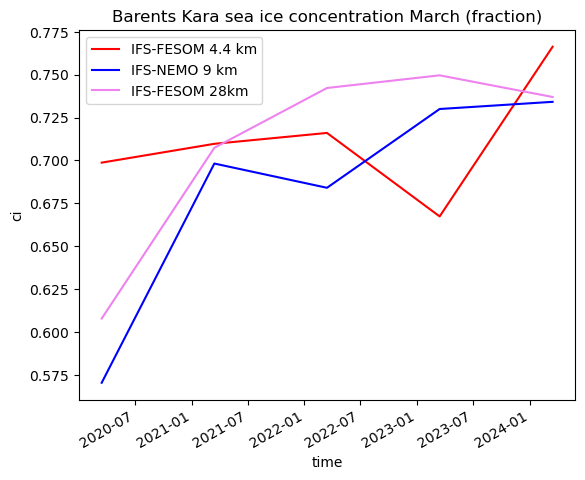

In [10]:
arc_ci.plot(color='red',label='IFS-FESOM 4.4 km')
arc_9km2_ci.plot(color='blue',label='IFS-NEMO 9 km')
#arc_9km1_ci.plot(color='green',label='IFS-FESOM 9 km') # Commenetd for time series plot(Only one year data)
arc_28km_ci.plot(color='violet',label='IFS-FESOM 28km')

plt.legend()
plt.title('Barents Kara sea ice concentration March (fraction)')
plt.savefig("Barents Kara Sea Ice_IFS_March.pdf")

In [11]:
## Now ICON

import intake

cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")
ds = cat.ICON.ngc3028(zoom=9).to_dask()  # this does NOT use dask, see note below
ds

icon_sic= ds['conc'].sel(time=ds.time.dt.month.isin([3])) # select month
icon_sic_mm=icon_sic.resample(time='1Y').mean()
icon_sic_mm

<xarray.DataArray 'conc' (time: 6, cell: 3145728)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2020-12-31 2021-12-31 ... 2025-12-31
Dimensions without coordinates: cell
Attributes:
    cell_methods:  time: mean cell: mean
    component:     ocean
    grid_mapping:  crs
    long_name:     ice concentration in each ice class
    vgrid:         generic_ice

In [12]:
import healpy as hp
import cartopy.crs as ccrs
import cartopy.feature as cf
import cmocean
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np

def nnshow(var, nx=1000, ny=1000, ax=None, **kwargs):
    """
    var: variable on healpix coordinates (array-like)
    nx: image resolution in x-direction
    ny: image resolution in y-direction
    ax: axis to plot on
    kwargs: additional arguments to imshow
    """
    if ax is None:
        ax = plt.gca()

    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    xvals = np.linspace(xlims[0], xlims[1], nx)
    yvals = np.linspace(ylims[0], ylims[1], ny)
    xvals2, yvals2 = np.meshgrid(xvals, yvals)
    latlon = ccrs.PlateCarree().transform_points(
        ax.projection, xvals2, yvals2, np.zeros_like(xvals2)
    )
    valid = np.all(np.isfinite(latlon), axis=-1)
    points = latlon[valid].T
    pix = hp.ang2pix(
        hp.npix2nside(len(var)), theta=points[0], phi=points[1], nest=True, lonlat=True
    )
    res = np.full(latlon.shape[:-1], np.nan, dtype=var.dtype)
    res[valid] = var[pix]
    return ax.imshow(res, extent=xlims + ylims, origin="lower", **kwargs)

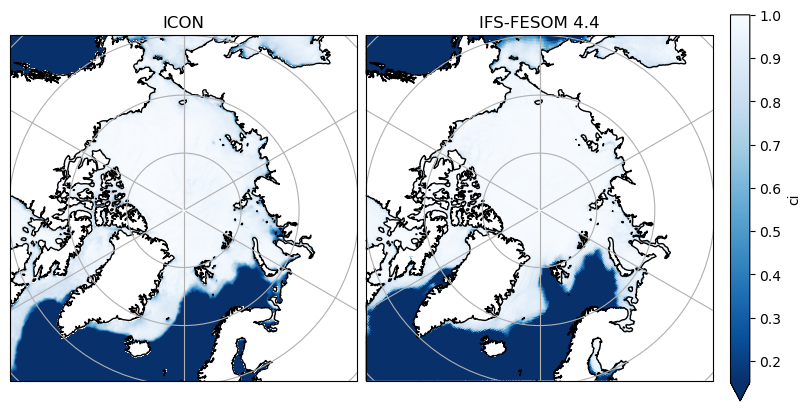

In [13]:
## Now Plot the ICON and IFS-FESOM 4.4

projection = ccrs.NorthPolarStereo()

fig, (ax1, ax2) = plt.subplots(1,2,
    figsize=(8, 4), subplot_kw={"projection": projection}, constrained_layout=True
)
# Limit the map to 60 degrees latitude and above:
ax1.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())


nnshow(icon_sic_mm.isel(time=3), ax=ax1, vmin=0.15,vmax=1, cmap=cm.Blues_r)
ax1.title.set_text('ICON')
ax1.coastlines()
ax1.gridlines()

ax2.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
ifs_ci_mon[3,:].plot(ax=ax2, transform=ccrs.PlateCarree(), vmin=0.15,vmax=1, cmap='Blues_r') 
# Add details to the plot:
ax2.title.set_text('IFS-FESOM 4.4')
ax2.coastlines();
ax2.gridlines();


In [18]:
# Regridding ICON data/Find the HEALPix pixels that are closest to the 1x1 degree grid points

lon = np.arange(0, 360, 1)
lat = np.arange(90, -91, -1)
pix = xr.DataArray(
    hp.ang2pix(ds.crs.healpix_nside, *np.meshgrid(lon, lat), nest=True, lonlat=True),
    coords=(("lat", lat), ("lon", lon)),
)

sic=icon_sic.isel(cell=pix)

arc_sic= wgt_areaave(sic, latS,latN,lonL,lonR)
arc_sic_mm=arc_sic.resample(time='1Y').mean()
arc_sic_mm


<xarray.DataArray 'conc' (time: 6)>
array([0.6694328 , 0.6687071 , 0.55654697, 0.61970343, 0.58156464,
       0.61488898])
Coordinates:
  * time     (time) datetime64[ns] 2020-12-31 2021-12-31 ... 2025-12-31

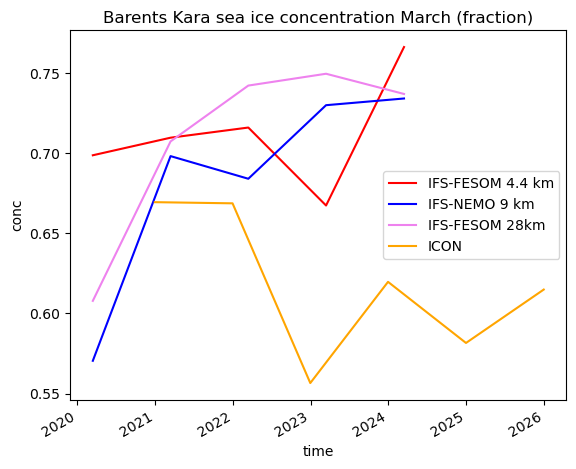

In [21]:
# Make a comparison of the time series of March BKS SIC
arc_ci.plot(color='red',label='IFS-FESOM 4.4 km')
arc_9km2_ci.plot(color='blue',label='IFS-NEMO 9 km')
#arc_9km1_ci.plot(color='green',label='IFS-FESOM 9 km')
arc_28km_ci.plot(color='violet',label='IFS-FESOM 28km')
arc_sic_mm.plot(color='orange',label='ICON')

plt.legend()
plt.title('Barents Kara sea ice concentration March (fraction)')
plt.savefig("Barents Kara Sea Ice_IFS_ICON_March.pdf")